In [84]:
!pip install albumentations==2.0.8
!pip install timm

In [85]:
!git clone https://github.com/parth1620/object-localization-dataset.git

fatal: destination path 'object-localization-dataset' already exists and is not an empty directory.


In [86]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [87]:
import timm
import torch.nn as nn
import torch.optim as optim

In [88]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configuration

In [89]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHs = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4


In [90]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


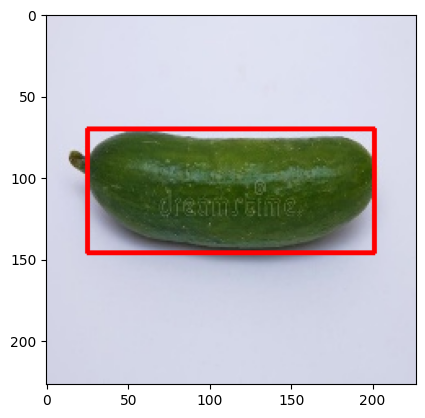

In [91]:
row = df.iloc[20]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt1 = (row.xmin, row.ymin)
plt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, plt1, plt2, (255, 0, 0), 2)
plt.imshow(bnd_box_img)

In [92]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

# Augmentation

In [93]:
import albumentations as A

In [94]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params = A.BboxParams(format="pascal_voc", label_fields= ['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params = A.BboxParams(format="pascal_voc", label_fields= ['class_labels']))

# Create custom dataset

In [95]:
class ObjDataset(torch.utils.data.Dataset):
  def __init__(self, df, augmentation=None):
    self.df = df
    self.augmentation = augmentation

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index]

    # Get original pixel coordinates of the bounding box
    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    # Bounding box in pixel coordinates for albumentations
    pixel_bbox = [xmin, ymin, xmax, ymax]

    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    current_img = img
    current_pixel_bbox = pixel_bbox

    if self.augmentation:
      # Pass original pixel coordinates and expect them back, potentially resized by A.Resize
      augmented = self.augmentation(image=img, bboxes=[pixel_bbox], class_labels=[None])
      current_img = augmented['image']

      if len(augmented['bboxes']) > 0:
        current_pixel_bbox = augmented['bboxes'][0]
      else:
        # If all bounding boxes are dropped by augmentation, revert to original image and bbox
        # This ensures a consistent (image, bbox) pair and prevents IndexError
        current_img = img
        current_pixel_bbox = pixel_bbox

    # Now, normalize the current (potentially augmented and resized) pixel bounding box
    # by the IMG_SIZE, which is the target size after A.Resize.
    normalized_bbox = [
        current_pixel_bbox[0] / IMG_SIZE,
        current_pixel_bbox[1] / IMG_SIZE,
        current_pixel_bbox[2] / IMG_SIZE,
        current_pixel_bbox[3] / IMG_SIZE
    ]

    img = torch.from_numpy(current_img).permute(2, 0, 1) / 255.0 # (h,w,c) --> (c,h,w)
    bbox = torch.tensor(normalized_bbox)
    return img, bbox

In [96]:
train_set = ObjDataset(train_df, train_augs)
valid_set = ObjDataset(valid_df, valid_augs)

In [97]:
print(f"Total example in train: {len(train_set)}")
print(f"Total example in valid: {len(valid_set)}")

Total example in train: 148
Total example in valid: 38


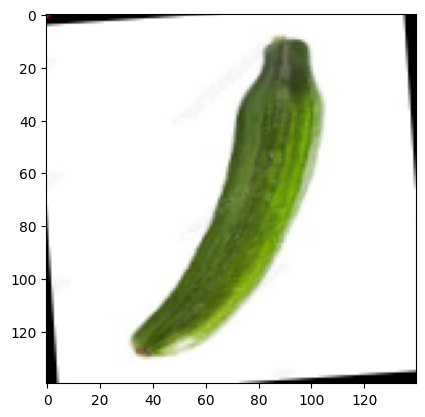

In [98]:
img, bbox = train_set[6]

xmin, ymin, xmax, ymax = bbox
plt1 = (int(xmin), int(ymin))
plt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1,2,0).numpy(), plt1, plt2, (255, 0, 0), 2)
plt.imshow(bnd_img)



# Load dataset into batches

In [99]:
import cv2
import numpy
import torch

import matplotlib.pyplot as plt

def compare_plots(image, gt_bbox, out_bbox, img_size=140):

    # Denormalize ground truth bbox
    xmin, ymin, xmax, ymax = gt_bbox * img_size

    pt1 = (int(xmin), int(ymin))
    pt2 = (int(xmax), int(ymax))

    # Denormalize predicted bbox
    out_xmin, out_ymin, out_xmax, out_ymax = out_bbox[0] * img_size

    out_pt1 = (int(out_xmin), int(out_ymin))
    out_pt2 = (int(out_xmax), int(out_ymax))

    # Convert image tensor to numpy array and scale to 0-255 for cv2
    # image.squeeze() removes the batch dimension
    # .permute(1, 2, 0) changes from (C, H, W) to (H, W, C)
    # .cpu().numpy() moves to CPU and converts to numpy
    # * 255 converts from [0, 1] float to [0, 255] float, then .astype(numpy.uint8) for cv2
    display_img = (image.squeeze().permute(1, 2, 0).cpu().numpy() * 255).astype(numpy.uint8)

    # Draw ground truth bbox (green)
    out_img = cv2.rectangle(display_img.copy(), pt1, pt2, (0, 255, 0), 2)
    # Draw predicted bbox (red)
    out_img = cv2.rectangle(out_img, out_pt1, out_pt2, (255, 0, 0), 2)

    plt.imshow(out_img)


In [100]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)

In [101]:
print(f"Total batch in train: {len(trainloader)}")
print(f"Total batch in valid: {len(validloader)}")

Total batch in train: 10
Total batch in valid: 3


In [102]:
for image, bbox in trainloader:
  break;

print(f"Shape of image: {image.shape}")
print(f"Shape of bbox: {bbox.shape}")




Shape of image: torch.Size([16, 3, 140, 140])
Shape of bbox: torch.Size([16, 4])


# Create Model

In [103]:
class ObjLocModel(nn.Module):
  def __init__(self):
    super(ObjLocModel, self).__init__()

    self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes = 4)

  def forward(self, images, gt_bboxes=None):
    bboxes = self.backbone(images)

    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss

    return bboxes

model = ObjLocModel()
model.to(DEVICE)

ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): C

In [104]:
random_img = torch.rand(1,3,140, 140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create train and eval function

In [105]:
from torch.utils.data import dataloader
def train_fn(model, trainloader, optimizer):
  total_loss = 0.0
  model.train()

  for data in tqdm(trainloader):
    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

    bboxes, loss = model(images, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(trainloader)

In [106]:
from torch.utils.data import dataloader
def eval_fn(model, validloader):
  total_loss = 0.0
  model.eval()
  with torch.no_grad():
      for data in tqdm(validloader):
        images, gt_bboxes = data
        images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

        bboxes, loss = model(images, gt_bboxes)

        total_loss += loss.item()

      return total_loss / len(validloader)

# Training loop

In [107]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [108]:
best_valid_loss = np.inf

for i in range(EPOCHs):

  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pth')
    best_valid_loss = valid_loss

  print(f"Epoch: {i+1} | Train Loss: {train_loss} | Valid Loss: {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 13.64421706199646 | Valid Loss: 12.15822950998942


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 2 | Train Loss: 8.054489612579346 | Valid Loss: 7.792871793111165


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 3 | Train Loss: 4.432812213897705 | Valid Loss: 2.104376792907715


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 4 | Train Loss: 2.093720281124115 | Valid Loss: 2.1709428230921426


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 5 | Train Loss: 1.140894842147827 | Valid Loss: 1.264460027217865


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6 | Train Loss: 0.6441844195127487 | Valid Loss: 0.6446605126063029


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7 | Train Loss: 0.4362123727798462 | Valid Loss: 0.34878402948379517


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 8 | Train Loss: 0.3170692786574364 | Valid Loss: 0.39679619669914246


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9 | Train Loss: 0.2772995173931122 | Valid Loss: 0.16388187805811563


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10 | Train Loss: 0.1959946259856224 | Valid Loss: 0.1681887706120809


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 11 | Train Loss: 0.14690808355808258 | Valid Loss: 0.1530451476573944


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12 | Train Loss: 0.10944013968110085 | Valid Loss: 0.11768228312333424


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13 | Train Loss: 0.09120461940765381 | Valid Loss: 0.08470916996399562


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14 | Train Loss: 0.09775590188801289 | Valid Loss: 0.08921285718679428


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15 | Train Loss: 0.07788619324564934 | Valid Loss: 0.08130566279093425


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16 | Train Loss: 0.0680522508919239 | Valid Loss: 0.07420442998409271


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17 | Train Loss: 0.059757910668849945 | Valid Loss: 0.06669584661722183


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 18 | Train Loss: 0.06717708557844163 | Valid Loss: 0.06132763375838598


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19 | Train Loss: 0.04906555451452732 | Valid Loss: 0.04437079777320226


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20 | Train Loss: 0.05099018737673759 | Valid Loss: 0.049693189561367035


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 21 | Train Loss: 0.05379396863281727 | Valid Loss: 0.043277827401955925


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22 | Train Loss: 0.04935975205153227 | Valid Loss: 0.04170503777762254


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23 | Train Loss: 0.05142793729901314 | Valid Loss: 0.0458945631980896


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24 | Train Loss: 0.038638554699718955 | Valid Loss: 0.03628165150682131


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25 | Train Loss: 0.041487427055835725 | Valid Loss: 0.031425525123874344


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26 | Train Loss: 0.0362059835344553 | Valid Loss: 0.03917254755894343


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27 | Train Loss: 0.03472522646188736 | Valid Loss: 0.03326295812924703


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28 | Train Loss: 0.03312730975449085 | Valid Loss: 0.04071475068728129


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29 | Train Loss: 0.0366987818852067 | Valid Loss: 0.03573491921027502


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30 | Train Loss: 0.04525604844093323 | Valid Loss: 0.04085525497794151


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31 | Train Loss: 0.03137816544622183 | Valid Loss: 0.02860221266746521


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 32 | Train Loss: 0.026340366620570422 | Valid Loss: 0.023973052700360615


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 33 | Train Loss: 0.024412378668785095 | Valid Loss: 0.022608851393063862


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34 | Train Loss: 0.021890216134488584 | Valid Loss: 0.02041835089524587


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35 | Train Loss: 0.024051971547305585 | Valid Loss: 0.027877734353144962


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36 | Train Loss: 0.028886148519814015 | Valid Loss: 0.02830435149371624


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 37 | Train Loss: 0.033491448126733304 | Valid Loss: 0.02222978292653958


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 38 | Train Loss: 0.02578753139823675 | Valid Loss: 0.02187682967633009


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 39 | Train Loss: 0.024393939785659312 | Valid Loss: 0.022438184668620426


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40 | Train Loss: 0.026731278281658888 | Valid Loss: 0.027428244551022846


# Inference

In [109]:
import utils


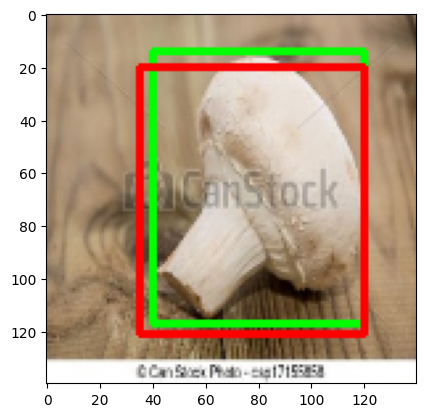

In [113]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

with torch.no_grad():
  image, gt_bbox = valid_set[23]
  image = image.unsqueeze(0).to(DEVICE)
  out_bbox = model(image)

  compare_plots(image, gt_bbox, out_bbox, IMG_SIZE)